# Computes Transmission Spectra (beta release)

We compute a high-resolution transmission spectrum using HITRAN CO and compare it with the results by the different method (by Yui Kawashima).
Note that `ArtTransPure` is `art` for the transmission spectrum.

In [1]:
from jax.config import config
import pandas as pd
import numpy as np
from exojax.utils.grids import wavenumber_grid
from exojax.spec.opacalc import OpaModit
from exojax.spec.atmrt import ArtTransPure
from exojax.utils.constants import RJ, Rs
from exojax.spec.api import MdbHitran
from exojax.utils.astrofunc import gravity_jupiter
    
config.update("jax_enable_x64", True)

/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:14: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


To load a reference spectrum, we make the following method.

In [2]:
def read_kawashima_data(filename):
    dat = pd.read_csv(filename, delimiter="   ")
    wav = dat["Wavelength[um]"]
    mask = (wav > 2.25) & (wav < 2.6)
    return wav[mask], dat["Rp/Rs"][mask]


The ref file should be in ExoJAX repo.

In [3]:
filename = "/home/kawahara/exojax/tests/integration/comparison/transmission/spectrum/CO100percent_500K.dat"

Here is the core code. We define `art` using `ArtTransPure`. 
`art.constant_mmr_profile` sets the mass mixing ratio layer profile to a constant value. Here we assume 100% CO everywhere.
For a transmission spectrum, the constant gravity assumption is not good approximation. So, we need to compute the gravity profile. 
`art.gravity_profile` does it. After computing opacity, we can use `art.run` to generate the transmission spectrum.

In [6]:
def compare_with_kawashima_code():
    mu_fid = 28.00863 #mean molecular weight
    T_fid = 500.

    Nx = 300000
    nu_grid, wav, res = wavenumber_grid(22900.0,
                                        26000.0,
                                        Nx,
                                        unit="AA",
                                        xsmode="modit")

    art = ArtTransPure(pressure_top=1.e-15, pressure_btm=1.e1, nlayer=100)
    art.change_temperature_range(490.0, 510.0)
    Tarr = T_fid * np.ones_like(art.pressure)
    mmr_arr = art.constant_mmr_profile(1.0)
    gravity_btm = gravity_jupiter(1.0, 1.0)
    radius_btm = RJ

    mdb = MdbHitran('CO', nu_grid, gpu_transfer=True)
    mmw = mu_fid * np.ones_like(art.pressure)
    gravity = art.gravity_profile(Tarr, mmw, radius_btm, gravity_btm)

    #HITRAN CO has not so many lines. So we use MODIT here instead of PreMODIT
    opa = OpaModit(mdb=mdb, nu_grid=nu_grid, Tarr_list=Tarr, Parr=art.pressure)
    xsmatrix = opa.xsmatrix(Tarr, art.pressure)
    dtau = art.opacity_profile_xs(xsmatrix, mmr_arr, opa.mdb.molmass,
                                     gravity)

    Rp2 = art.run(dtau, Tarr, mmw, radius_btm, gravity_btm)
    return nu_grid, np.sqrt(Rp2) * radius_btm / Rs


Compares the results. Not so bad. Note that the Kawashima-san's reference includes the Rayleigh scattering, but we do not. That makes this small difference.

/tmp/ipykernel_40805/4154571916.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dat = pd.read_csv(filename, delimiter="   ")


xsmode =  modit
xsmode assumes ESLOG in wavenumber space: mode=modit
We changed the policy of the order of wavenumber/wavelength grids
wavenumber grid shluld be in ascending order and now 
users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
This might causes the bug if you update ExoJAX. 
Note that the older ExoJAX assumes ascending order as wavelength grid.


/home/kawahara/exojax/src/exojax/spec/atmrt.py:43: UserWarning: nu_grid is not given. specify nu_grid when using 'run' 
  warnings.warn(


k= 0.6892612104349697
k= 0.6892612104349697


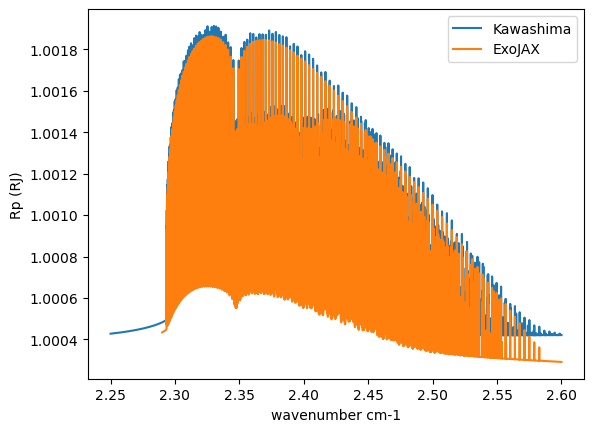

In [7]:
import matplotlib.pyplot as plt

wav, rprs = read_kawashima_data(filename)
diffmode = 1
nus_hitran, Rp_hitran = compare_with_kawashima_code()
from exojax.spec.unitconvert import nu2wav
wav_exojax = nu2wav(nus_hitran, unit="um", wavelength_order="ascending")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(wav, rprs * Rs / RJ, label="Kawashima")
#plt.yscale("log")
ax.plot(wav_exojax[::-1], Rp_hitran * Rs / RJ, label="ExoJAX")
plt.legend()

plt.xlabel("wavenumber cm-1")
#plt.ylim(-0.07, 0.07)
plt.legend()
plt.ylabel("Rp (RJ)")

plt.savefig("comparison.png")
plt.show()
